In [1]:
import tensorflow as tf
import pickle 
from sklearn.preprocessing import StandardScaler

file1 = open('X_beam.pkl', 'rb')
file2 = open('Y_beam_2.pkl', 'rb')
X1=pickle.load(file1)
file1.close()
Y1=pickle.load(file2)
file2.close()
# Scale targets
N, L, D = Y1.shape
Y_flat = Y1.reshape(-1, D)
scaler = StandardScaler().fit(Y_flat)
Y1 = scaler.transform(Y_flat).reshape(N, L, D)
X=X1[:480,:]


2025-07-19 14:22:39.080148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 14:22:39.142907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-19 14:22:39.215022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-19 14:22:39.229084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 14:22:39.264733: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class MLP(tf.keras.Model):
    def __init__(self, features, layer_norm=False, **kwargs):
        # Accept any extra keyword arguments, such as 'trainable'
        super(MLP, self).__init__(**kwargs)
        self.layers_list = [layers.Dense(feat, activation='tanh', dtype=tf.float64) for feat in features[:-1]]
        self.layers_list += [layers.Dense(features[-1], dtype=tf.float64)]
        
        if layer_norm:
            self.layers_list.append(layers.LayerNormalization(dtype=tf.float64))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x
    
    def get_config(self):
        # It's a good practice to include the configuration for custom models.
        base_config = super(MLP, self).get_config()
        config = {
            "features": [layer.units for layer in self.layers_list if isinstance(layer, layers.Dense)],
            "layer_norm": any(isinstance(layer, layers.LayerNormalization) for layer in self.layers_list)
        }
        return dict(list(base_config.items()) + list(config.items()))
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
@register_keras_serializable()  
class GraphNetwork(tf.keras.Model):
    def __init__(self, node_dim, edge_dim, global_dim, message_dim, output_dim, num_steps, **kwargs):
        # Accept any extra keyword arguments (e.g., 'trainable') and pass them to the base class.
        super(GraphNetwork, self).__init__(**kwargs)
        # Store parameters for get_config and from_config
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.global_dim = global_dim
        self.message_dim = message_dim
        self.output_dim = output_dim
        self.num_steps = num_steps

        # Initializing layers
        self.node_encoder = MLP([128, 128, node_dim])
        self.edge_encoder = MLP([128, 128, edge_dim])
        self.message_fn = MLP([128, 128, message_dim], layer_norm=True)
        self.node_update_fn = MLP([128, 128, node_dim], layer_norm=True)
        self.edge_update_fn = MLP([128, 128, edge_dim], layer_norm=True)
        self.global_update_fn = MLP([128, 128, global_dim])
        self.decoder = MLP([128, 128, output_dim])

    def call(self, nodes, edges, senders, receivers, global_attr, training=False):
        node_features = self.node_encoder(nodes)
        edge_features = self.edge_encoder(edges)
        
        for _ in range(self.num_steps):
            sender_features = tf.gather(node_features, senders)
            receiver_features = tf.gather(node_features, receivers)
            message_inputs = tf.concat([sender_features, receiver_features, edge_features], axis=-1)
            messages = self.message_fn(message_inputs)
            # Update node and edge features
            node_features += tf.math.unsorted_segment_sum(messages, receivers, num_segments=tf.shape(node_features)[0])
            edge_features += messages

        global_attr = tf.expand_dims(global_attr, axis=0)
        global_features = self.global_update_fn(global_attr)
        expanded_globals = tf.tile(global_features, [tf.shape(node_features)[0], 1])
        decoded_nodes = self.decoder(node_features + expanded_globals)
        
        return decoded_nodes

    def get_config(self):
        config = super(GraphNetwork, self).get_config()
        config.update({
            "node_dim": self.node_dim,
            "edge_dim": self.edge_dim,
            "global_dim": self.global_dim,
            "message_dim": self.message_dim,
            "output_dim": self.output_dim,
            "num_steps": self.num_steps
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Instantiate the model
model2 = GraphNetwork(
    node_dim=128,
    edge_dim=128,
    global_dim=128,
    message_dim=128,
    output_dim=20,
    num_steps=10
)



In [9]:
model2.load_weights("gnn.weights.h5")

In [5]:
import numpy as np
# Load edge, node data, and labels from .npy files
edges = np.load('new_edge.npy')[:480,:,2].reshape((480, 630, 1))
senders=np.load('new_edge.npy')[:480,:,0]
receivers=np.load('new_edge.npy')[:480,:,1]
nodes = np.load('Test_Node.npy')[:480]
targets = np.load('Test_dis.npy').reshape((500,231,2*10))[:480]
global_params = np.load('beam_test.npy')[:480]


# Assuming 'targets' is a TensorFlow tensor that needs to be normalized
target_mean = tf.reduce_mean(targets, axis=[0, 1])  # Calculate the mean across specified axes
target_std = tf.math.reduce_std(targets, axis=[0, 1])  # Calculate the standard deviation across specified axes

# Normalize the targets
normalised_targets = (targets - target_mean) / target_std

train_node_data = tf.convert_to_tensor(nodes, dtype=tf.float64)
train_edges = tf.convert_to_tensor(edges, dtype=tf.float64)
senders = tf.convert_to_tensor(senders, dtype=tf.int64)  # Flatten and pick the first case
receivers = tf.convert_to_tensor(receivers, dtype=tf.int64)  # Flatten and pick the first case
train_global_data = tf.convert_to_tensor(global_params, dtype=tf.float64)
labels = tf.convert_to_tensor(normalised_targets, dtype=tf.float64)  # Flatten and pick the first case



In [60]:
# model= tf.keras.models.load_model(
#     "saved_model_GNN.keras",
#     custom_objects={"GraphNetwork": GraphNetwork, "MLP": MLP},
#     compile=False
# )

In [61]:
@tf.function
def loss_fn(model, nodes, edges, senders, receivers, global_attr, targets):
    total_loss = tf.constant(0.0, dtype=tf.float64)  # Start with a float64 constant
    for i in tf.range(nodes.shape[0]):
        predictions = model(nodes[i], edges[i], senders[i], receivers[i], global_attr[i], training=True)
        loss = tf.reduce_mean(tf.square(predictions - targets[i]))
        total_loss += loss
    return total_loss / tf.cast(nodes.shape[0], dtype=tf.float64)

In [62]:
@tf.function
def train_step(model, optimizer, train_node_data, train_edges, senders, receivers, train_global_data, targets):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, train_node_data, train_edges, senders, receivers, train_global_data, targets)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
epochs = 800
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
# best_val_loss = float('inf')
best_val_loss = float(0.00725)
for epoch in range(epochs):
    loss = train_step(model2, optimizer, train_node_data, train_edges, senders, receivers, train_global_data, labels)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    if loss < best_val_loss:
        best_val_loss = loss
        # model2.save('saved_model_GNN.keras')
        # model2.save_weights("gnn2.weights.h5")

/home/pgrad2/2670035g/anaconda3/envs/gnnEmulEnv/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'graph_network_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-07-19 14:21:41.830022: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-07-19 14:21:41.830778: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-07-19 14:21:41.830867: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-07-19 14:21:41.831049: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-07-19 14:21:41.831129: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-07-19 14:21:41.832730: W tensorflow/core/util/util.cc:161] Not handling t

In [ ]:
# Load edge, node data, and labels from .npy files
edges = np.load('new_edge.npy')[:480,:,2].reshape((480, 630, 1))
senders=np.load('new_edge.npy')[:480,:,0]
receivers=np.load('new_edge.npy')[:480,:,1]
nodes = np.load('Test_Node.npy')[:480]
targets = np.load('Test_dis.npy').reshape((500,231,2*10))[:480]
global_params = np.load('beam_test.npy')[:480]

In [10]:
pred1=model2(train_node_data[13], train_edges[13], senders[13], receivers[13], train_global_data[13])
# pred1=model2(train_node_data[1], train_edges[1], senders[1], receivers[1], train_global_data[1])
test_pred=pred1*target_std+target_mean

In [11]:
pre_field=train_node_data[13]+tf.gather(test_pred, [4,14], axis=1)
real_field= train_node_data[13]+tf.gather(targets[13], [4,14], axis=1)

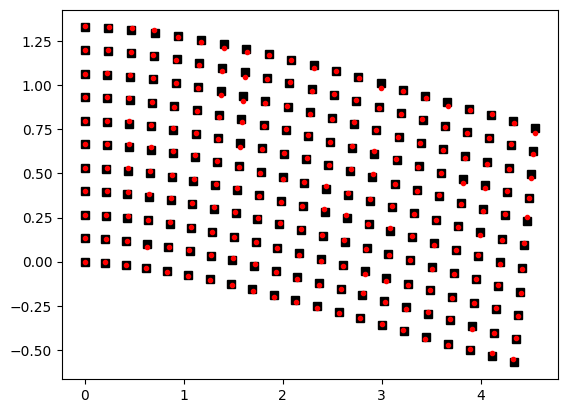

In [12]:
import matplotlib.pyplot as plt
plt.plot(real_field[:,0], real_field[:,1], 'ks')
plt.plot(pre_field[:,0], pre_field[:,1], 'ro', markersize=3  )

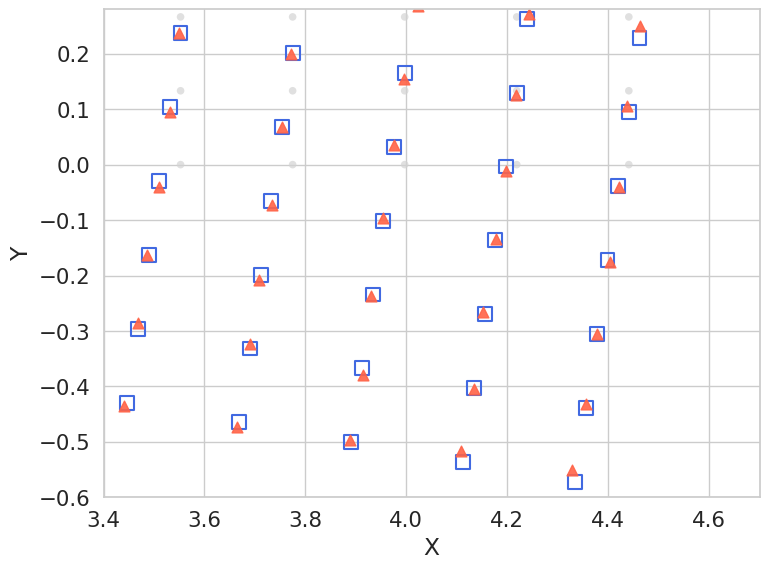

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设定风格
sns.set(style="whitegrid", font_scale=1.4)  # 白底网格，稍大字号

# 2. 新建画布
fig, ax = plt.subplots(figsize=(8, 6))

# 3. 绘制三类点
# 3.1 初始节点（浅灰小圆点）
ax.scatter(
    train_node_data[13,:,0], train_node_data[13,:,1],
    s=30,                      # 点大小
    c="lightgrey",             # 填充色
    marker="o",                # 圆点
    edgecolors="none",         # 无边缘
    alpha=0.7,                 # 透明度
    label="Initial"
)

# 3.2 Ground-truth （蓝色空心方块）
ax.scatter(
    real_field[:,0], real_field[:,1],
    s=100,
    facecolors="none",         # 空心
    edgecolors="royalblue",    # 边缘色
    linewidth=1.5,
    marker="s",                # 方块
    label="Ground Truth"
)

# 3.3 Prediction （红色实心三角）
ax.scatter(
    pre_field[:,0], pre_field[:,1],
    s=60,
    c="tomato",
    marker="^",                # 上三角
    alpha=0.9,
    label="Prediction"
)

# 4. 坐标轴、标题、图例
# ax.set_title("Node Positions: Initial vs. Ground Truth vs. Prediction", pad=12)
ax.set_xlabel("X")
ax.set_ylabel("Y")
# ax.legend(
#     # loc="upper right",
#     frameon=True,
#     fancybox=True,
#     shadow=True,
#     borderpad=0.6
# )

# 5. 等比例显示、去掉右上脊梁
# ax.set_aspect("equal", "box")
# sns.despine(trim=True)
plt.xlim(3.4,4.7)
plt.ylim(-0.6,0.28)
plt.tight_layout()
plt.show()


In [ ]:
print(model.get_config())           # 保存前的 config
print(model2.get_config())          # 载入后的 config
print(len(model.weights), len(model2.weights))

{'name': 'graph_network_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'node_dim': 128, 'edge_dim': 128, 'global_dim': 128, 'message_dim': 128, 'output_dim': 20, 'num_steps': 10}
{'name': 'graph_network_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'node_dim': 128, 'edge_dim': 128, 'global_dim': 128, 'message_dim': 128, 'output_dim': 20, 'num_steps': 10}
32 32


In [ ]:
# Save the model using the SavedModel format
model2.save_weights("gnn.weights.h5")

In [ ]:
# then restore
model.load_weights("gnn.weights.h5")